In [7]:
import sys
sys.path.append('../')

import numpy
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,KNeighborsClassifier)
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from scipy.spatial import distance
from keras.layers import SimpleRNN
from keras.models import Sequential

from b3data.stocks import Stocks, CLOSING
from b3data.utils.stock_util import  StockUtil
from b3data.utils.smote import duplicate_data
from insiders.models.densegru import DenseGRU
from insiders.models.denselstm import DenseLSTM
from validators.plotters.plotter_utils import Plotter

### Getting stock data

In [8]:
stockutil = StockUtil(['PETR3'], [9])
prices, preds = stockutil.average_prices_preds()
plotter = Plotter()

### Slice dataset in training data and test data

In [9]:
train_proportion = 0.7

train_size = int(len(prices[0]) * train_proportion)

train_x = prices[0][0:train_size]
test_x = prices[0][train_size:len(prices[0])]
train_y = preds[0][0:train_size]
test_y = preds[0][train_size:len(prices[0])]

In [10]:
stocks = Stocks(year=2014, cod='PETR3', period=6)
dataset = stocks.selected_fields([CLOSING])

### Testing on LSTM

ccuracy: 0.8095 - f1_m: 0.3571 - precision_m: 0.3571 - recall_m: 0.3571
Epoch 4833/5000
84/84 - 0s - loss: 0.3669 - accuracy: 0.8452 - f1_m: 0.3571 - precision_m: 0.3571 - recall_m: 0.3571
Epoch 4834/5000
84/84 - 0s - loss: 0.3717 - accuracy: 0.7857 - f1_m: 0.3571 - precision_m: 0.3571 - recall_m: 0.3571
Epoch 4835/5000
84/84 - 0s - loss: 0.3699 - accuracy: 0.7976 - f1_m: 0.3571 - precision_m: 0.3571 - recall_m: 0.3571
Epoch 4836/5000
84/84 - 0s - loss: 0.3711 - accuracy: 0.7976 - f1_m: 0.3571 - precision_m: 0.3571 - recall_m: 0.3571
Epoch 4837/5000
84/84 - 0s - loss: 0.3696 - accuracy: 0.7976 - f1_m: 0.3571 - precision_m: 0.3571 - recall_m: 0.3571
Epoch 4838/5000
84/84 - 0s - loss: 0.3707 - accuracy: 0.8095 - f1_m: 0.3571 - precision_m: 0.3571 - recall_m: 0.3571
Epoch 4839/5000
84/84 - 0s - loss: 0.3713 - accuracy: 0.8095 - f1_m: 0.3571 - precision_m: 0.3571 - recall_m: 0.3571
Epoch 4840/5000
84/84 - 0s - loss: 0.3721 - accuracy: 0.7976 - f1_m: 0.3571 - precision_m: 0.3571 - recall_m:

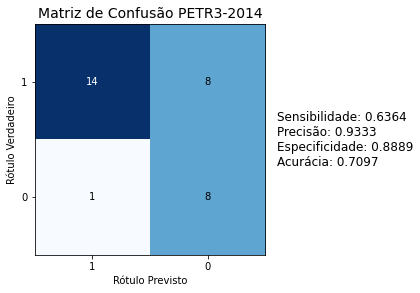

In [36]:
lstm = DenseLSTM(look_back=6, dense=True)
lstm.create_data_for_fit(dataset)
result = lstm.fit_and_evaluate(batch_size=1, epochs=5000)
print("accuracy: " + str(result['acc']))
conf_mat = result['cm']
plotter.plot_confusion_matrix(conf_mat[0],
                              conf_mat[1],
                              'PETR3', '2014',
                              'CLOSING', 6)

### Testing on KNN

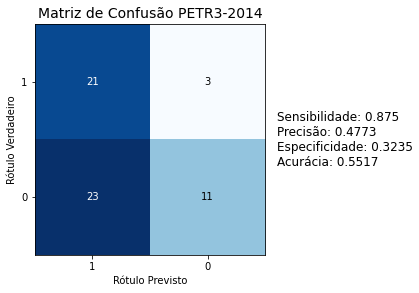

In [22]:
def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = numpy.matrix(numpy.ones((an+1,bn+1)) * numpy.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = numpy.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]


X = numpy.array(train_x).reshape(len(train_x), 1)
Y = train_y

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

neigh = KNeighborsRegressor(n_neighbors=1, metric=DTW)
neigh.fit(X, Y)
X_test = numpy.array(test_x).reshape(len(test_x), 1)

X_test = scaler.fit_transform(X_test)

score = 0
y_preds = []
for i, pred in enumerate(neigh.predict(X_test)):
    if pred >= 0.5:
        y_preds.append(1)
    else:
        y_preds.append(0)

plotter.plot_confusion_matrix(test_y,
                              y_preds,
                              'PETR3', '2014',
                              'CLOSING', 6)

### Testing on LSTM optimized

In [12]:
lstm = DenseLSTM(look_back=6, dense=1, lstm_cells=50)
lstm.create_data_for_fit(dataset)
result = lstm.fit_and_evaluate(batch_size=1, epochs=5000)
print("accuracy: " + str(result['acc']))
conf_mat = result['cm']
plotter.plot_confusion_matrix(conf_mat[0],
                              conf_mat[1],
                              'PETR3', '2014',
                              'CLOSING', 6)

ion_m: 0.3690 - recall_m: 0.3690
Epoch 649/5000
84/84 - 0s - loss: 0.3965 - accuracy: 0.8333 - f1_m: 0.3690 - precision_m: 0.3690 - recall_m: 0.3690
Epoch 650/5000
84/84 - 0s - loss: 0.3944 - accuracy: 0.7857 - f1_m: 0.3452 - precision_m: 0.3452 - recall_m: 0.3452
Epoch 651/5000
84/84 - 0s - loss: 0.3862 - accuracy: 0.8333 - f1_m: 0.3810 - precision_m: 0.3810 - recall_m: 0.3810
Epoch 652/5000
84/84 - 0s - loss: 0.3866 - accuracy: 0.8095 - f1_m: 0.3690 - precision_m: 0.3690 - recall_m: 0.3690
Epoch 653/5000
84/84 - 0s - loss: 0.3972 - accuracy: 0.8095 - f1_m: 0.3810 - precision_m: 0.3810 - recall_m: 0.3810
Epoch 654/5000
84/84 - 0s - loss: 0.3983 - accuracy: 0.8333 - f1_m: 0.3690 - precision_m: 0.3690 - recall_m: 0.3690
Epoch 655/5000
84/84 - 0s - loss: 0.3940 - accuracy: 0.8214 - f1_m: 0.3571 - precision_m: 0.3571 - recall_m: 0.3571
Epoch 656/5000
84/84 - 0s - loss: 0.3844 - accuracy: 0.7976 - f1_m: 0.3690 - precision_m: 0.3690 - recall_m: 0.3690
Epoch 657/5000
84/84 - 0s - loss: 0.372

KeyboardInterrupt: 

### Testing on GRU

0.3690
Epoch 4825/5000
84/84 - 0s - loss: 0.3263 - acc: 0.8452 - f1_m: 0.3690 - precision_m: 0.3690 - recall_m: 0.3690
Epoch 4826/5000
84/84 - 0s - loss: 0.3307 - acc: 0.8452 - f1_m: 0.3690 - precision_m: 0.3690 - recall_m: 0.3690
Epoch 4827/5000
84/84 - 0s - loss: 0.3282 - acc: 0.8452 - f1_m: 0.3690 - precision_m: 0.3690 - recall_m: 0.3690
Epoch 4828/5000
84/84 - 0s - loss: 0.3279 - acc: 0.8452 - f1_m: 0.3690 - precision_m: 0.3690 - recall_m: 0.3690
Epoch 4829/5000
84/84 - 0s - loss: 0.3263 - acc: 0.8452 - f1_m: 0.3690 - precision_m: 0.3690 - recall_m: 0.3690
Epoch 4830/5000
84/84 - 0s - loss: 0.3276 - acc: 0.8452 - f1_m: 0.3690 - precision_m: 0.3690 - recall_m: 0.3690
Epoch 4831/5000
84/84 - 0s - loss: 0.3296 - acc: 0.8452 - f1_m: 0.3690 - precision_m: 0.3690 - recall_m: 0.3690
Epoch 4832/5000
84/84 - 0s - loss: 0.3290 - acc: 0.8452 - f1_m: 0.3690 - precision_m: 0.3690 - recall_m: 0.3690
Epoch 4833/5000
84/84 - 0s - loss: 0.3281 - acc: 0.8452 - f1_m: 0.3690 - precision_m: 0.3690 - re

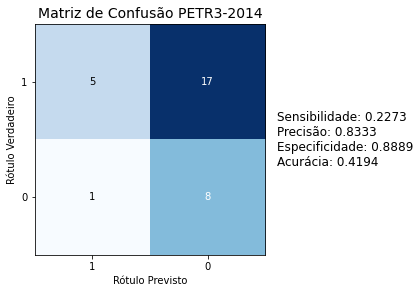

In [21]:
gru = DenseGRU(look_back=6, dense=True)
gru.create_data_for_fit(dataset)
result = gru.fit_and_evaluate(batch_size=1, epochs=5000)
print("accuracy: " + str(result['acc']))
conf_mat = result['cm']
plotter.plot_confusion_matrix(conf_mat[0],
                              conf_mat[1],
                              'PETR3', '2014',
                              'CLOSING', 6)

### Testing on SVM

... C=1, epsilon=0.01, kernel=poly, total=   0.0s
[CV] C=1, epsilon=0.01, kernel=sigmoid ...............................
[CV] ................ C=1, epsilon=0.01, kernel=sigmoid, total=   0.0s
[CV] C=1, epsilon=0.01, kernel=sigmoid ...............................
[CV] ................ C=1, epsilon=0.01, kernel=sigmoid, total=   0.0s
[CV] C=1, epsilon=0.01, kernel=sigmoid ...............................
[CV] ................ C=1, epsilon=0.01, kernel=sigmoid, total=   0.0s
[CV] C=1, epsilon=0.01, kernel=sigmoid ...............................
[CV] ................ C=1, epsilon=0.01, kernel=sigmoid, total=   0.0s
[CV] C=1, epsilon=0.01, kernel=sigmoid ...............................
[CV] ................ C=1, epsilon=0.01, kernel=sigmoid, total=   0.0s
[CV] C=1, epsilon=0.001, kernel=rbf ..................................
[CV] ................... C=1, epsilon=0.001, kernel=rbf, total=   0.0s
[CV] C=1, epsilon=0.001, kernel=rbf ..................................
[CV] ................... C=

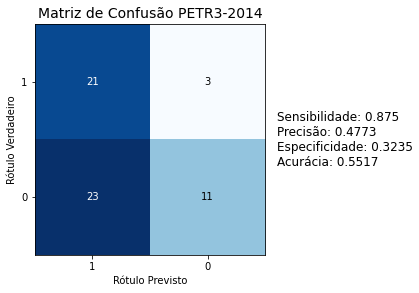

In [23]:
param_grid = {'C': [0.1,1, 10, 100], 
              'epsilon': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=2)
grid.fit(X,Y)

svr = grid.best_estimator_
svr.predict(X_test)

y_preds = []
for i, pred in enumerate(neigh.predict(X_test)):
    if pred >= 0.5:
        y_preds.append(1)
    else:
        y_preds.append(0)

grid.best_estimator_.get_params()

plotter.plot_confusion_matrix(test_y,
                              y_preds,
                              'PETR3', '2014',
                              'CLOSING', 6)

### Testing on RNN


Epoch 4664/5000
3/3 - 0s - loss: 0.5024 - accuracy: 0.7857
Epoch 4665/5000
3/3 - 0s - loss: 0.5024 - accuracy: 0.7857
Epoch 4666/5000
3/3 - 0s - loss: 0.5024 - accuracy: 0.7857
Epoch 4667/5000
3/3 - 0s - loss: 0.5023 - accuracy: 0.7857
Epoch 4668/5000
3/3 - 0s - loss: 0.5023 - accuracy: 0.7857
Epoch 4669/5000
3/3 - 0s - loss: 0.5023 - accuracy: 0.7857
Epoch 4670/5000
3/3 - 0s - loss: 0.5023 - accuracy: 0.7857
Epoch 4671/5000
3/3 - 0s - loss: 0.5023 - accuracy: 0.7857
Epoch 4672/5000
3/3 - 0s - loss: 0.5023 - accuracy: 0.7857
Epoch 4673/5000
3/3 - 0s - loss: 0.5023 - accuracy: 0.7857
Epoch 4674/5000
3/3 - 0s - loss: 0.5022 - accuracy: 0.7857
Epoch 4675/5000
3/3 - 0s - loss: 0.5023 - accuracy: 0.7857
Epoch 4676/5000
3/3 - 0s - loss: 0.5023 - accuracy: 0.7857
Epoch 4677/5000
3/3 - 0s - loss: 0.5022 - accuracy: 0.7857
Epoch 4678/5000
3/3 - 0s - loss: 0.5022 - accuracy: 0.7857
Epoch 4679/5000
3/3 - 0s - loss: 0.5022 - accuracy: 0.7857
Epoch 4680/5000
3/3 - 0s - loss: 0.5021 - accuracy: 0.7

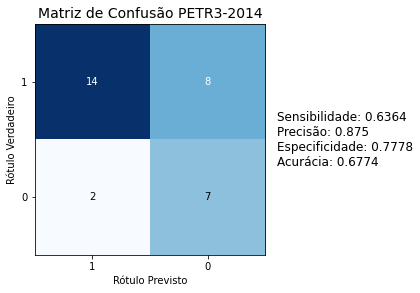

In [17]:
model = Sequential()

model.add(SimpleRNN(activation="sigmoid", units=1))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(gru.train_x, gru.train_y, epochs=5000, verbose=2)
result = model.evaluate(gru.test_x, gru.test_y)
print('accuracy: ' + str(result[1]))
rnn_pred = [int(round(pred[0])) for pred in model.predict(gru.test_x)]
plotter.plot_confusion_matrix(gru.test_y,
                              rnn_pred,
                              'PETR3', '2014',
                              'CLOSING', 6)